# 以PTT NBA版做文字視覺化分析球員及球隊討論聲量並以最高聲量球員做進階分析

In [2]:
import pandas as pd
import numpy as np
import time
import json
from collections import Counter
import jieba
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook
from module.text_module import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.animation as animation
from fintextmin import *
import re
from wordcloud import WordCloud
from ast import literal_eval
from IPython.display import HTML
import seaborn as sns
import torch.nn.functional as F
import torch
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#設定字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

## 預處理+Over view

將預先爬下來的文章讀入

In [65]:
df = pd.read_csv("NBA_crawler1.csv", index_col=0)

取出Po文的類別

In [66]:
df['type'] = df['標題'].apply(lambda x: x.split(" ")[0])

統計每個類別出現次數

In [67]:
Counter(list(df['type'])).most_common()[:20]

[('[情報]', 3415),
 ('Re:', 3060),
 ('[討論]', 3043),
 ('[新聞]', 2528),
 ('[花邊]', 2400),
 ('[Live]', 1368),
 ('[公告]', 593),
 ('[外絮]', 515),
 ('[專欄]', 328),
 ('[BOX', 85),
 ('Fw:', 76),
 ('[發錢]', 52),
 ('[徵文]', 37),
 ('[分享]', 14),
 ('[出售]', 7),
 ('[心得]', 7),
 ('[祭品]', 5),
 ('[版務]', 4),
 ('[公告]水桶', 4),
 ('[發錢', 4)]

In [68]:
df = df[df['type'].isin(['[情報]','[討論]','[新聞]','[花邊]','[外絮]','[專欄]'])]
df.reset_index(drop=True, inplace=True)
df.head()

標題                        時間  \
0      [新聞] 湯瑪斯重返波士頓 厄文：球迷會歡迎他  Mon Jan  1 13:33:18 2018   
1    [新聞] 哈登夾人手還可以罰球 湖迷怒轟:裁判瞎了  Mon Jan  1 14:06:18 2018   
2        [新聞] 火箭總管：打敗勇士是我們唯一目標  Mon Jan  1 14:11:35 2018   
3  [花邊] Irving談對騎士:很期待，這會是一個考驗  Mon Jan  1 14:27:36 2018   
4   [花邊] NBA》科爾振奮：柯瑞復出 讓我老婆變美了  Mon Jan  1 15:36:31 2018   

                               作者  \
0             StressND (rmgooddd)   
1          Wojnarowski (@wojespn)   
2                       Yui5 (唯控)   
3  KyrieIrving1 (King of Celtics)   
4                   lovea (lovea)   

                                                  內文  \
0  \nhttps://nba.udn.com/nba/story/6780/2905733\n...   
1  \nNBA》哈登夾人手還可以罰球 湖迷怒轟：裁判瞎了？（影音）\n\n〔體育中心／綜合報導〕...   
2  \n火箭總管：打敗勇士是我們唯一目標\nhttp://www.chinatimes.com/...   
3  \nIrving談下場對陣騎士：很期待，這會是一個考驗\n\n虎撲1月1日訊\n\n在今天以...   
4  \nNBA》科爾振奮：柯瑞復出 讓我老婆變美了\n\nhttp://www.chinatim...   

                                                留言作者  \
0  [m791017, jenchieh5, jlincredible, aaron770708...   
1  [LENling, obryanto, mafitelak, arcss, swinging...   
2  [live147222, adamlovedogc, yuechen, yuechen, S...   
3  [hunt5566, she192224, woaifafewen, yuechen, wa...   
4  [tim1112, goal56, grayoasis, ilovedandan, Nana...   

                                                  留言  type  
0  [: 新大哥說話了！！, : 瑪斯:, : 有風度推, :  燒球衣歡迎, : 商場 球場 ...  [新聞]  
1  [: 剛剛那篇怎麼被刪了, : 這球滿誇張, : 突然發現op了就自刪ㄌ, : 鬍子慢動作手...  [新聞]  
2  [: 唯一目標是冠軍, : 還勇士 雷霆馬刺都不一定過關了, : 先打贏雷霆跟馬刺, : 不...  [新聞]  
3  [: 1:0, : Kyrie MVP, : 會去教LBJ做人, : 未看先猜LeBron守...  [花邊]  
4  [: 女為悅己者容, : 這麼綠也能高興@@, : Op, : 又在講幹話了, : 綠綠的,...  [花邊]

取得時間中的月份

In [71]:
df['month'] = df['時間'].apply(lambda x:x.split(" ")[1])

將月份轉換為數字

In [72]:
month = df.groupby('month').count().reset_index()
month['index'] = month['month']
month_index = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
month['index'] = month['index'].map(month_index)
month = month.sort_values(by='index')

在PTT個月份的NBA討論熱度

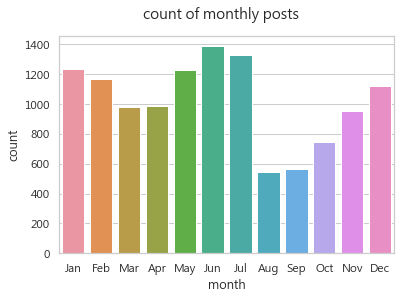

In [73]:
sns.countplot('month',data=df)
plt.suptitle('count of monthly posts')
plt.savefig('countofmonth')

## TF-IDF

#### jieba斷詞處理

In [74]:
doc_names = range(len(df))
text_list = list(df['內文'])

dwc = {key: [word for word in jieba.cut(text, cut_all=False)] for (key, text) in tqdm_notebook(zip(doc_names, text_list))}

#### 先用re把不需要的刪掉

In [11]:
#算次數之前先整理
def delete_eng_int(x_list):
    r1 = '[a-zA-Z0-9’!"#$─%&\'()*+,-.：/:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    x_list = [re.sub(r1,'', i).strip() for i in x_list]
    while '' in x_list:
        x_list.remove('')
    return x_list
dwc = {key: delete_eng_int(doc) for key,doc in dwc.items()}

#### 除特殊字元外有些PTT特有但也需要刪除的字

In [66]:
dwc = {key: [i for i in doc if i not in ['◣','▲','－','▼','違反版','違反板','規請','資料','來源','錯誤','如有','告訴','謝謝','Ｗ','L','Ｌ','的','在','了','是']]for key,doc in dwc.items()}
dwc = {key: [i for i in doc if (len(i) > 1)]for key,doc in dwc.items()}
doc_word_frequency = {key: {i:Counter(doc)[i] for i in Counter(doc)} for key, doc in dwc.items()}

#### 可以在每篇統計出現次數

In [69]:
list(doc_word_frequency[1].items())[0:10]

[('哈登', 10),
 ('人手', 1),
 ('可以', 1),
 ('罰球', 2),
 ('湖迷怒', 1),
 ('裁判', 6),
 ('影音', 1),
 ('體育', 1),
 ('中心', 1),
 ('綜合', 1)]

#### 有些斷詞完所有都被刪除因此需要補no進去(Nan為float type不補的話會出錯)

In [71]:
dwf_list = [pd.DataFrame(list(doc.values()), index=doc.keys()) for doc in doc_word_frequency.values()]
#找有哪些沒東西
nothing  = [i for i in range(len(dwf_list)) if (len(dwf_list[i]) < 1)]
#將他補為No的DataFrame
pd.DataFrame(1,index=['No'],columns=[0])

0
No  1

#### 完成詞頻矩陣 word-frequency 

In [72]:
dwf_list = [pd.DataFrame(list(doc.values()), index=doc.keys()) for doc in doc_word_frequency.values()]
#補齊
for i in nothing:
    dwf_list[i] = pd.DataFrame(1,index=['No'],columns=[0])
    
wfm = pd.concat(dwf_list, axis= 1)
wfm = np.transpose(wfm).fillna(0)
wfm.index = doc_word_frequency.keys()

puncs = set_puncs() 
wfm = wfm[list(set(wfm) - set(puncs))]
wfm.head() # 詞頻矩陣完成

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


法逆勢   寄給  兩腳間   並陳  森的場   完需  偏高為   種夥   紅樓   貝力  ...   滿天   阿特   看計  迎來後衛  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   0.0   

    別聊   少領   必癢   相近   討教   待會  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 108436 columns]

#### tf-idf矩陣

In [413]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf_gen = transformer.fit_transform(wfm) # 產生一個 tfidf 矩陣的 generator
df_tfidf = pd.DataFrame(tfidf_gen.toarray(), columns=wfm.columns)
df_tfidf.head()

票來  二連勝   人浪  不會罰   許有  叫的數  看不懂   忡忡   謝天  據美國  ...   比餅   勝負   首次  最後到  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    單幹   並長  灣時間  蘇思睿  醫來當   注一  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 26531 columns]

#### TF-IDF看出什麼是這篇文章的重點討論主題

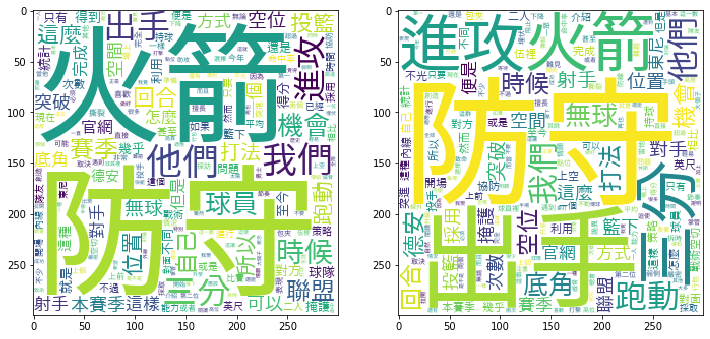

In [415]:
#第562篇文章
index = 562
first_text = wfm.to_dict(orient='records')[index] # 將詞頻矩陣轉換成dictionary, 把文章抽出來

font = r'/Users/howardchung/PPT/字體/TaipeiSansTCBeta-Regular.ttf'

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plot_wordcloud(first_text, ax=ax1, font_path=font, height=300, width=300)

ax2 = plt.subplot(122)
plot_tfidf_wordcloud(df_tfidf, text_index=562, ax=ax2, font_path=font, height=300, width=300) 

#### 以詞頻長條圖展示

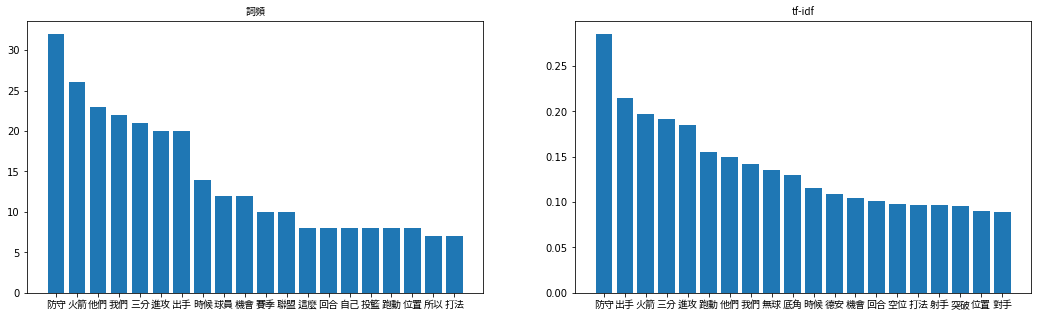

In [417]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
plot_tf_bar(first_text, ax=ax1, font_path=font, title="詞頻")

ax2 = plt.subplot(122)
plot_tfidf_bar(df_tfidf, text_index=562, ax=ax2, font_path=font, title="tf-idf") 

### 接下來以文章或留言討論內容數量做視覺化

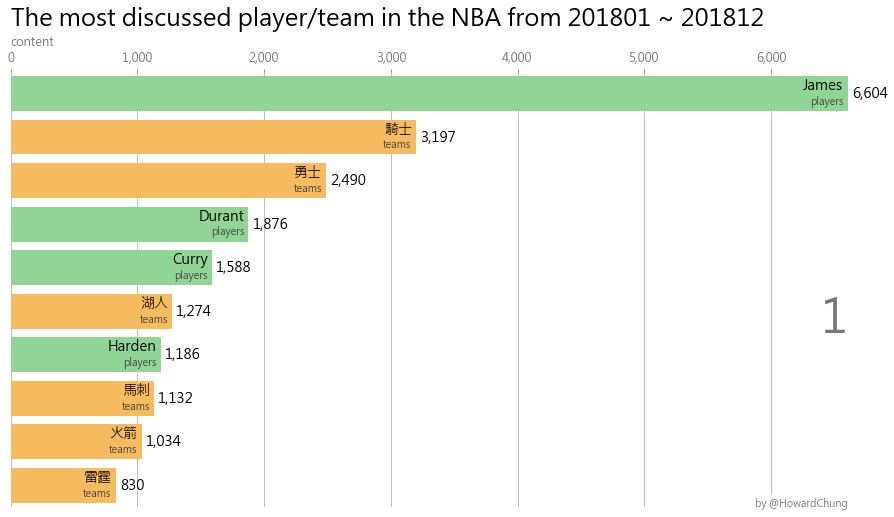

In [42]:
rank = pd.read_csv('rank.csv',index_col=0)
group_lk = rank.set_index('name')['group'].to_dict()
colors = dict(zip(
    ["players","teams"],
    ["#90d595", "#f7bb5f"]
))

fig, ax = plt.subplots(figsize=(15, 8))

def draw_barchart(current_year):
    dff = rank[rank['month'].eq(current_year)].sort_values(by='count', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['name'], dff['count'], color=[colors[group_lk[x]] for x in dff['name']])
    dx = dff['count'].max() / 200
    for i, (value, name) in enumerate(zip(dff['count'], dff['name'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.4, current_year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'content', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'The most discussed player/team in the NBA from 201801 ~ 201812',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    ax.text(1, 0, 'by @HowardChung', transform=ax.transAxes, color='#777777', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    
draw_barchart(1)

#### 球員/球隊聲量月份統計變化

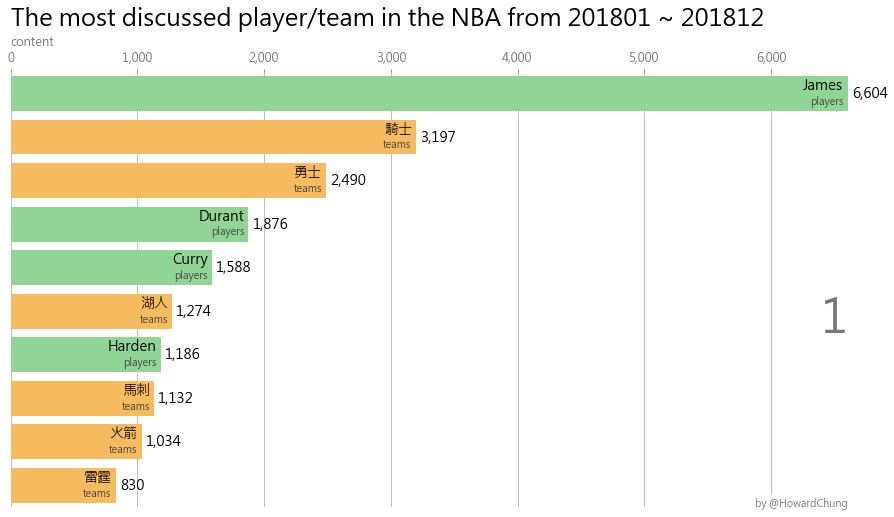

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 13))
HTML(animator.to_jshtml())

#### 月份變化量推論出來的事件

[3月火箭討論量成長原因]
<img src='./img/2.png' style='zoom:40%'>
------------------------------------------------------------------------------------------------------------------------------------------------
<img src='./img/1.png' style='zoom:32%'>
------------------------------------------------------------------------------------------------------------------------------------------------ <br /> 
[5月Durant討論量成長原因]
<img src='./img/3.png' style='zoom:42%'>
------------------------------------------------------------------------------------------------------------------------------------------------<br /> 
[7月James,馬刺隊討論量成長原因]
<img src='./img/4.png' style='zoom:58%'>
------------------------------------------------------------------------------------------------------------------------------------------------
<img src='./img/5.png' style='zoom:60%'>

#### 球隊聲量統計

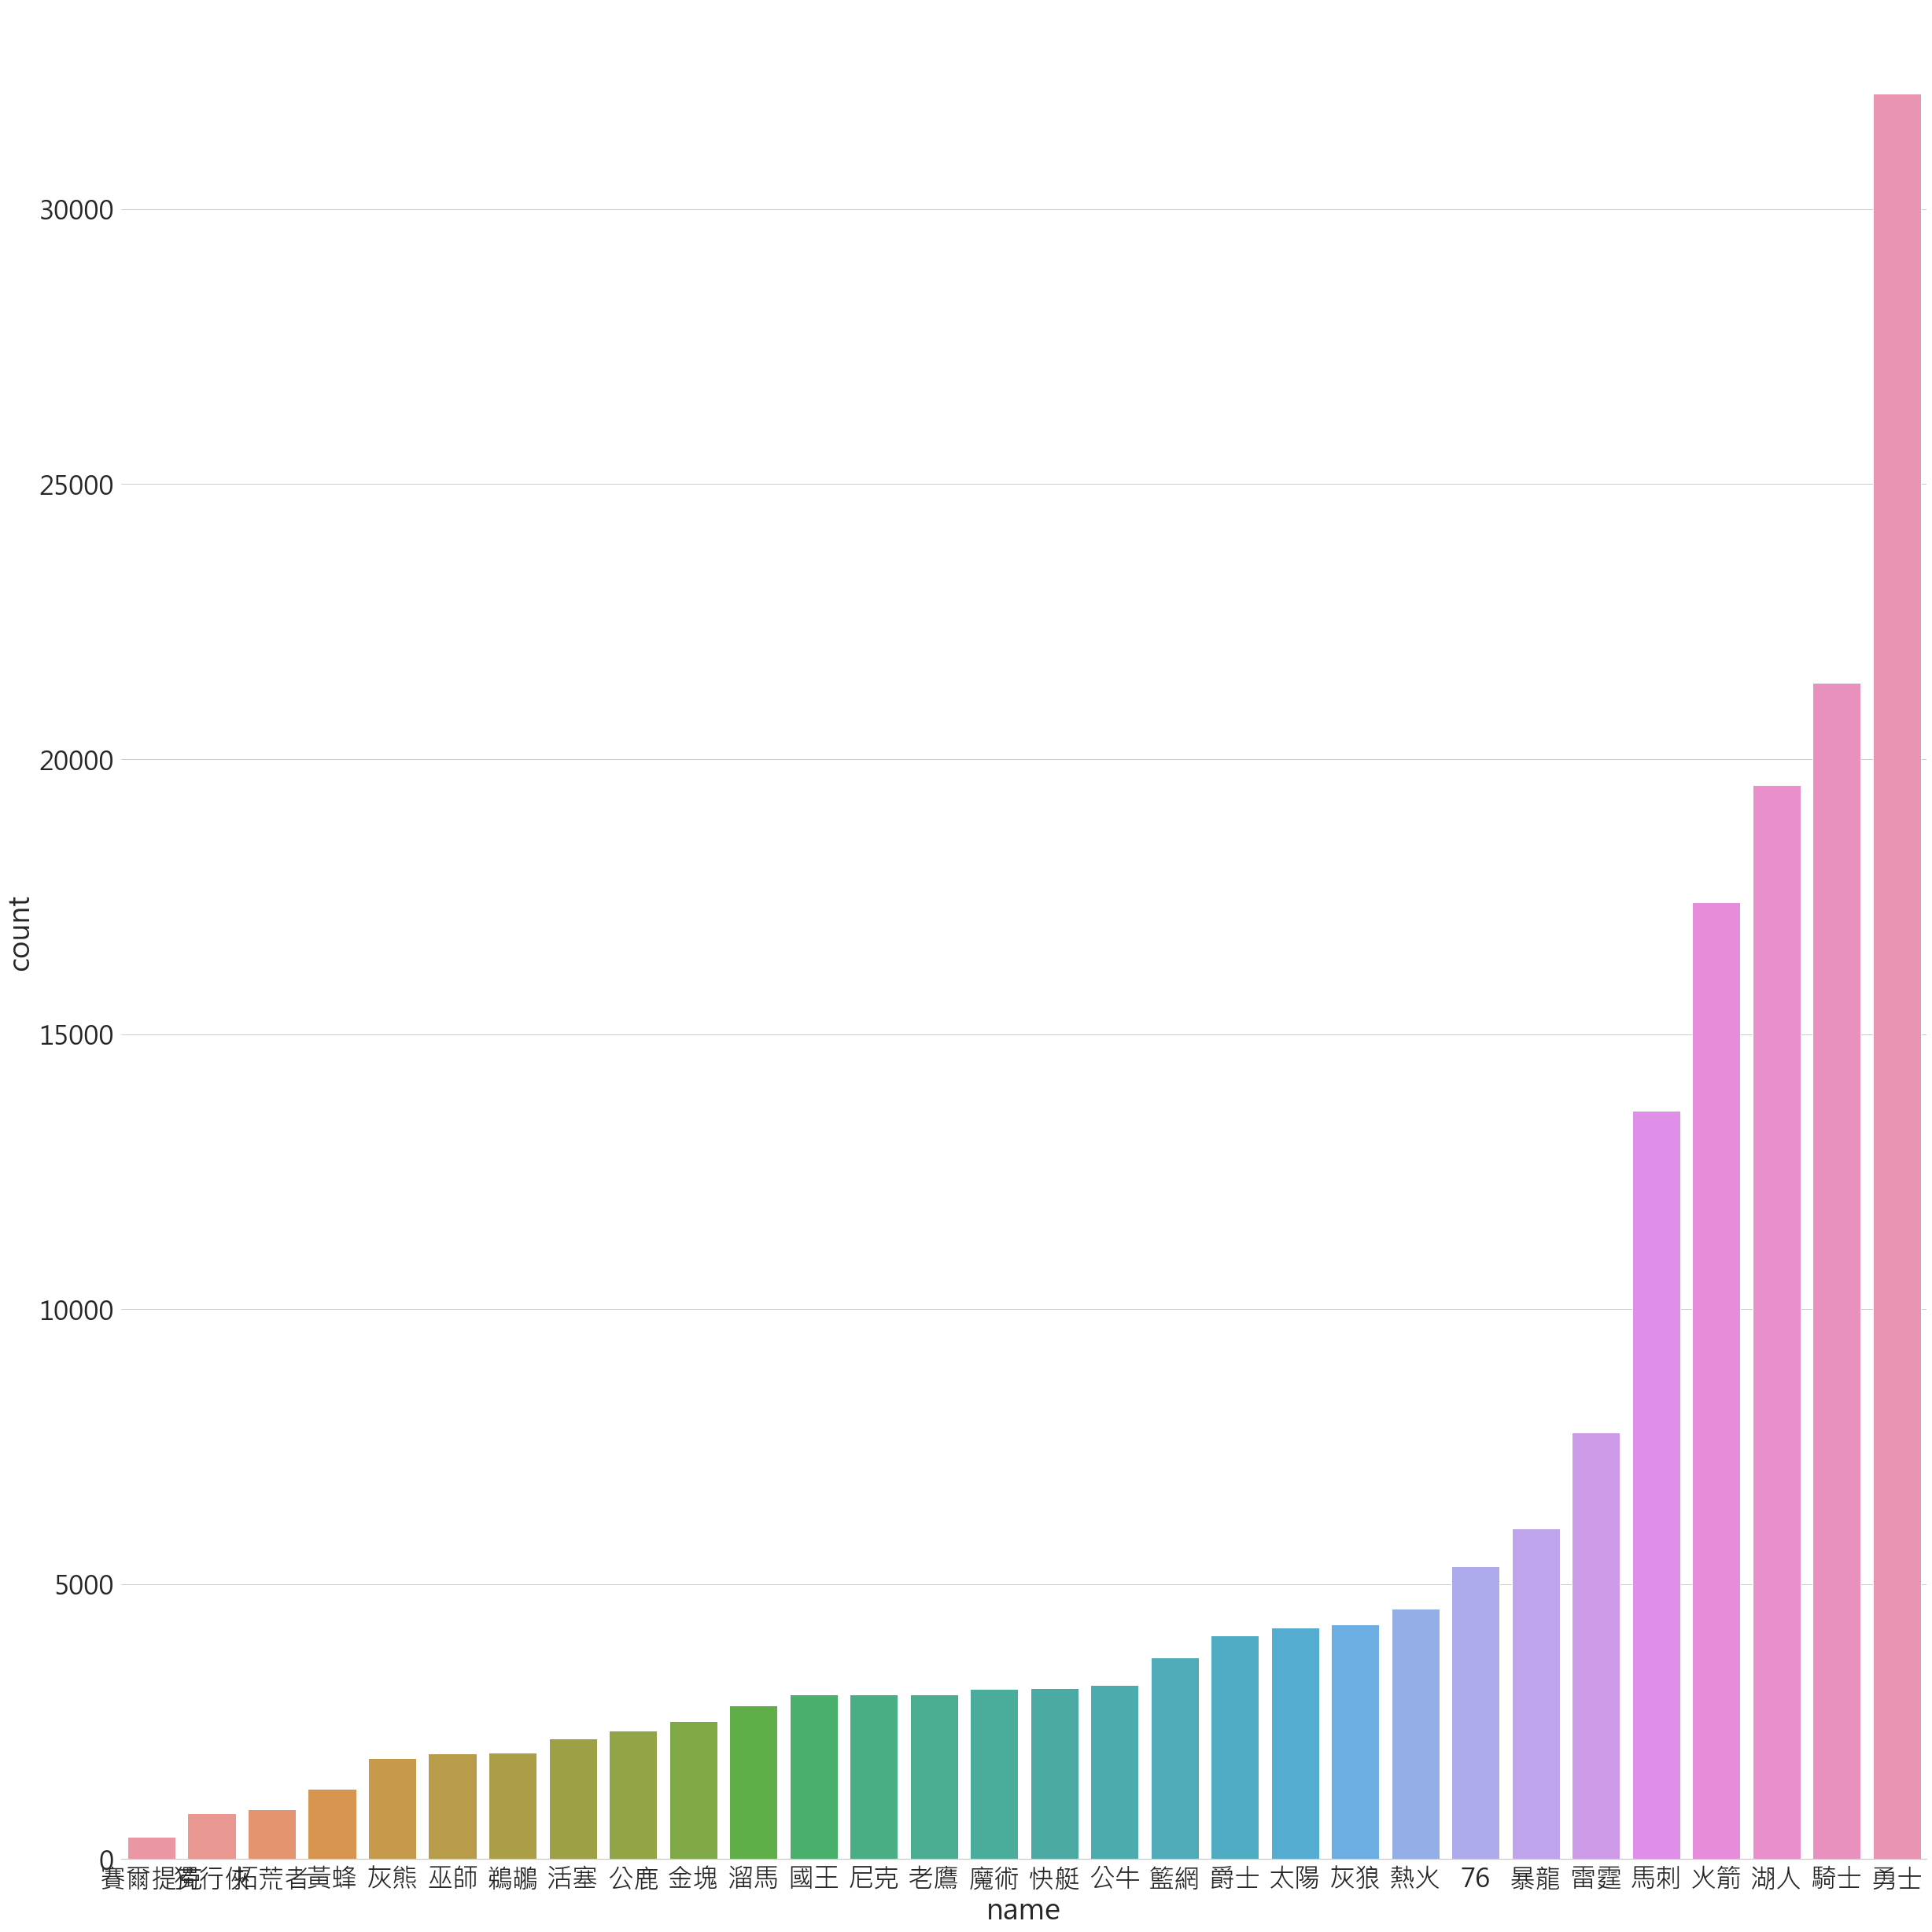

In [47]:
team_rank = rank[rank['group']=='teams'].groupby('name').sum().reset_index().sort_values(by='count')

myfont=FontProperties(fname=r'/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/msj.ttf',size=14)
sns.set(font=myfont.get_family())
sns.set(font_scale=3)
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
g = sns.catplot(x="name",y="count",data=team_rank,kind="bar",height = 35)
g.despine(left=True)
g = g.set_ylabels("count")
g.savefig('count_by_team')

討論量高皆為有進季後賽後半或是有球星加盟之隊伍

#### 馬刺沒什麼出色表現聲量怎麼會高？

Kawhi轉隊導致7月討論量爆量成長

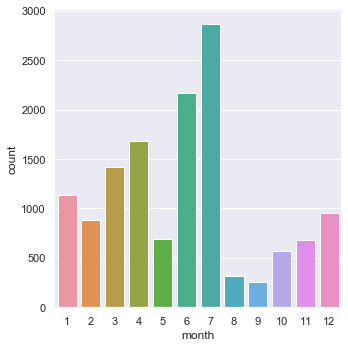

In [185]:
spurs = rank[rank['name'] == '馬刺']
sns.set(font_scale=1)
g = sns.catplot(x="month",y="count",data=spurs,kind="bar")
g.despine(left=True)
g = g.set_ylabels("count")

### 最後對聯盟討論量最高的James做分析

#### 爬蟲NBA版只取LBJ


In [5]:
with open('NBA.json', 'r', encoding='utf-8') as f:
    data = [json.loads(d.strip('\n')) for d in f.readlines()]
f.close()
df = pd.DataFrame(data)

#### Over view

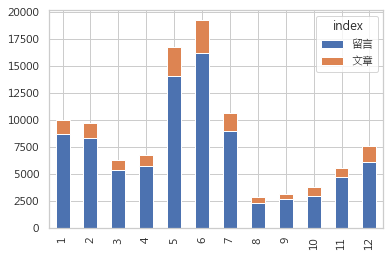

In [103]:
times_c = {}
for i in range(12):
    times_c[i+1] = len(df['評論'][0][i])

times_co = {}
for i in range(12):
    times_co[i+1] = len(df['內文'][0][i])
    
x = pd.DataFrame(times_c,index=range(1))
x = pd.concat([x,pd.DataFrame(times_co,index=range(1))]).reset_index()
x['index'] = ['留言','文章']
x.set_index('index').T.plot(kind='bar', stacked=True)
plt.savefig('留言文章比')

#### Bert最多只能吃510個字以下,所以刪除長篇大論

In [136]:
x = sum(df['內文'][0],[])

for i in reversed(range(len(x))):
    if len(x[i]) > 510:
        del x[i]

### BERT

In [9]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-chinese', do_basic_tokenize=True)
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-chinese')    # 將放在雲端上面的BERT模型下載下來
model.eval() # 將模型設爲預測模式

def preprocess(sent, masked_indices=None): # 將句子編碼成編號向量，順便用[MASK]遮住我們想考BERT的字
    text = "[CLS]" + sent + "[SEP]"
    tokenized_text = tokenizer.tokenize(text)
    masked_tokens = []
    if masked_indices is not None:
        for masked_index in masked_indices:
            print("tokenized_text before masking: {}".format(tokenized_text))
            masked_tokens.append(tokenized_text[masked_index])
            tokenized_text[masked_index] = '[MASK]'
            print("tokenized_text after masking: {}".format(tokenized_text))

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_ids = [0] * len(tokenized_text)
    segments_tensors = torch.tensor([segments_ids])
    if masked_indices is not None:
        return masked_tokens, tokens_tensor, segments_tensors
    else:
        return tokens_tensor, segments_tensors

sents = x
error=[]
with torch.no_grad(): # 請模型不要計算訓練時會用到的梯度(gradient)，減少記憶體用量及加快計算速度
    embeddings = [] #初始化BERT字向量的list
    keyword_index = tokenizer.convert_tokens_to_ids(["詹姆士"])[0]#拿取「詹姆士」這個字在BERT內部的編號
    j=-1
    for sent in tqdm_notebook(sents): # 對所有在上面的list裡面的句子都計算BERT的考慮上下文的字向量
        j+=1
        try:
            tokens_tensor, segments_tensors = preprocess(sent) # 把中文字轉換成BERT看得懂的編號向量
            encoded_layers, _ = model(tokens_tensor, segments_tensors) # 計算BERT字向量
            keyword_position = torch.nonzero(tokens_tensor[0] == keyword_index)[0][0] # 拿取句子裡第一次出現的「果」字在句子中的位置
            embeddings.append(encoded_layers[0, keyword_position]) # 拿取句子裡第一個「果」字的向量，並加入BERT字向量的list中
        except:
            print(j)
            error.append(j)

for i in reversed(error):
    del x[i]
    
sents = x
error=[]
with torch.no_grad(): # 請模型不要計算訓練時會用到的梯度(gradient)，減少記憶體用量及加快計算速度
    embeddings = [] #初始化BERT字向量的list
    keyword_index = tokenizer.convert_tokens_to_ids(["詹姆士"])[0]#拿取「詹姆士」這個字在BERT內部的編號
    for sent in tqdm_notebook(sents): # 對所有在上面的list裡面的句子都計算BERT的考慮上下文的字向量
        tokens_tensor, segments_tensors = preprocess(sent) # 把中文字轉換成BERT看得懂的編號向量
        encoded_layers, _ = model(tokens_tensor, segments_tensors) # 計算BERT字向量
        keyword_position = torch.nonzero(tokens_tensor[0] == keyword_index)[0][0] # 拿取句子裡第一次出現的「果」字在句子中的位置
        embeddings.append(encoded_layers[0, keyword_position]) # 拿取句子裡第一個「果」字的向量，並加入BERT字向量的list中

Using cache found in /Users/howardchung/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /Users/howardchung/.cache/torch/hub/huggingface_pytorch-transformers_master


In [11]:
#先複製一份embeddings
new_embeddings = embeddings
#儲存embeddings
np.save('new_embeddings', new_embeddings)

### PCA

/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


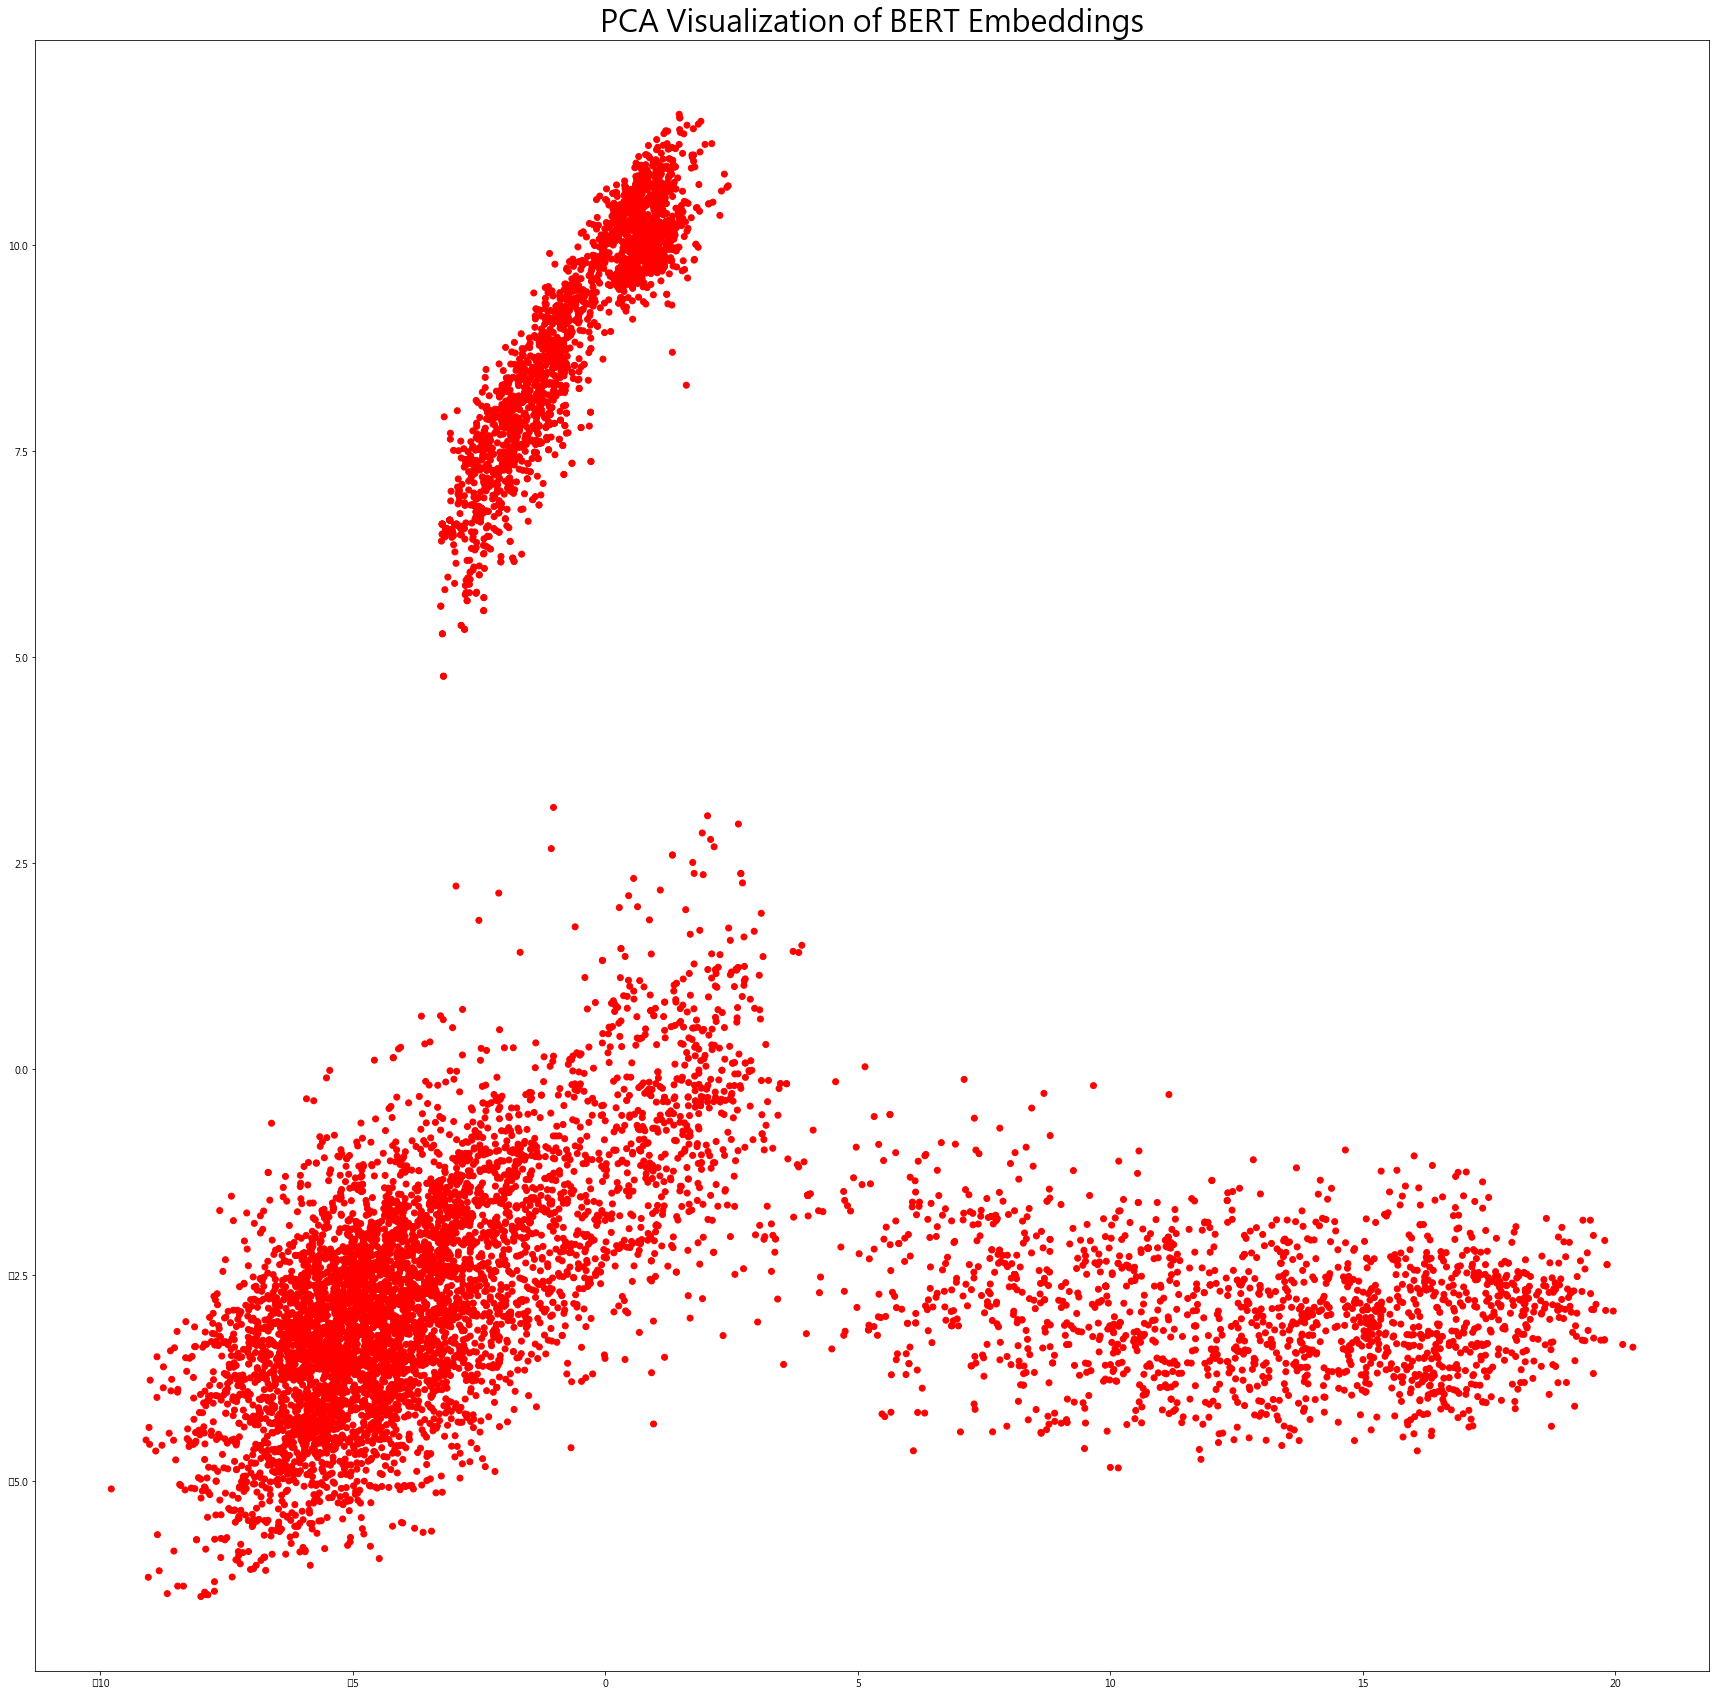

In [12]:
#PCA
embeddings = torch.stack(embeddings, dim=0) 

fig, axes = plt.subplots(figsize=(30, 30))

# 每個BERT字向量都有768維，我們用PCA演算法將他們降維到2維空間以便進行視覺化
pca=PCA(n_components=3) 
pca.fit(embeddings) 
pca_embeddings = pca.transform(embeddings)

colors = ['r'] * len(sents)

#將PCA降維的結果畫在第一行的畫布上
axes.scatter(pca_embeddings[:,0], pca_embeddings[:,1], c=colors)

#把標題寫上去
axes.set_title("PCA Visualization of BERT Embeddings", fontsize=30)
#for i, txt in enumerate(apple_sents):
    #在每個點旁邊寫上「」的字向量的所屬句子（上下文）
    #axes.annotate(txt, (pca_embeddings[i,0], pca_embeddings[i,1]), fontproperties=fontprop)

plt.savefig('pca.png')

In [13]:
#儲存embeddings
np.save('pca_embeddings', pca_embeddings)

### KMeans

In [5]:
pca_embeddings  = np.load('pca_embeddings.npy')

In [6]:
X = pca_embeddings[:,0:2]

In [27]:
#用KMeans分成三群
km = KMeans(n_clusters=3,
                    init='random',
                    max_iter=300,
                    tol=1e-04,
                    random_state=0)

y_km = km.fit_predict(X)

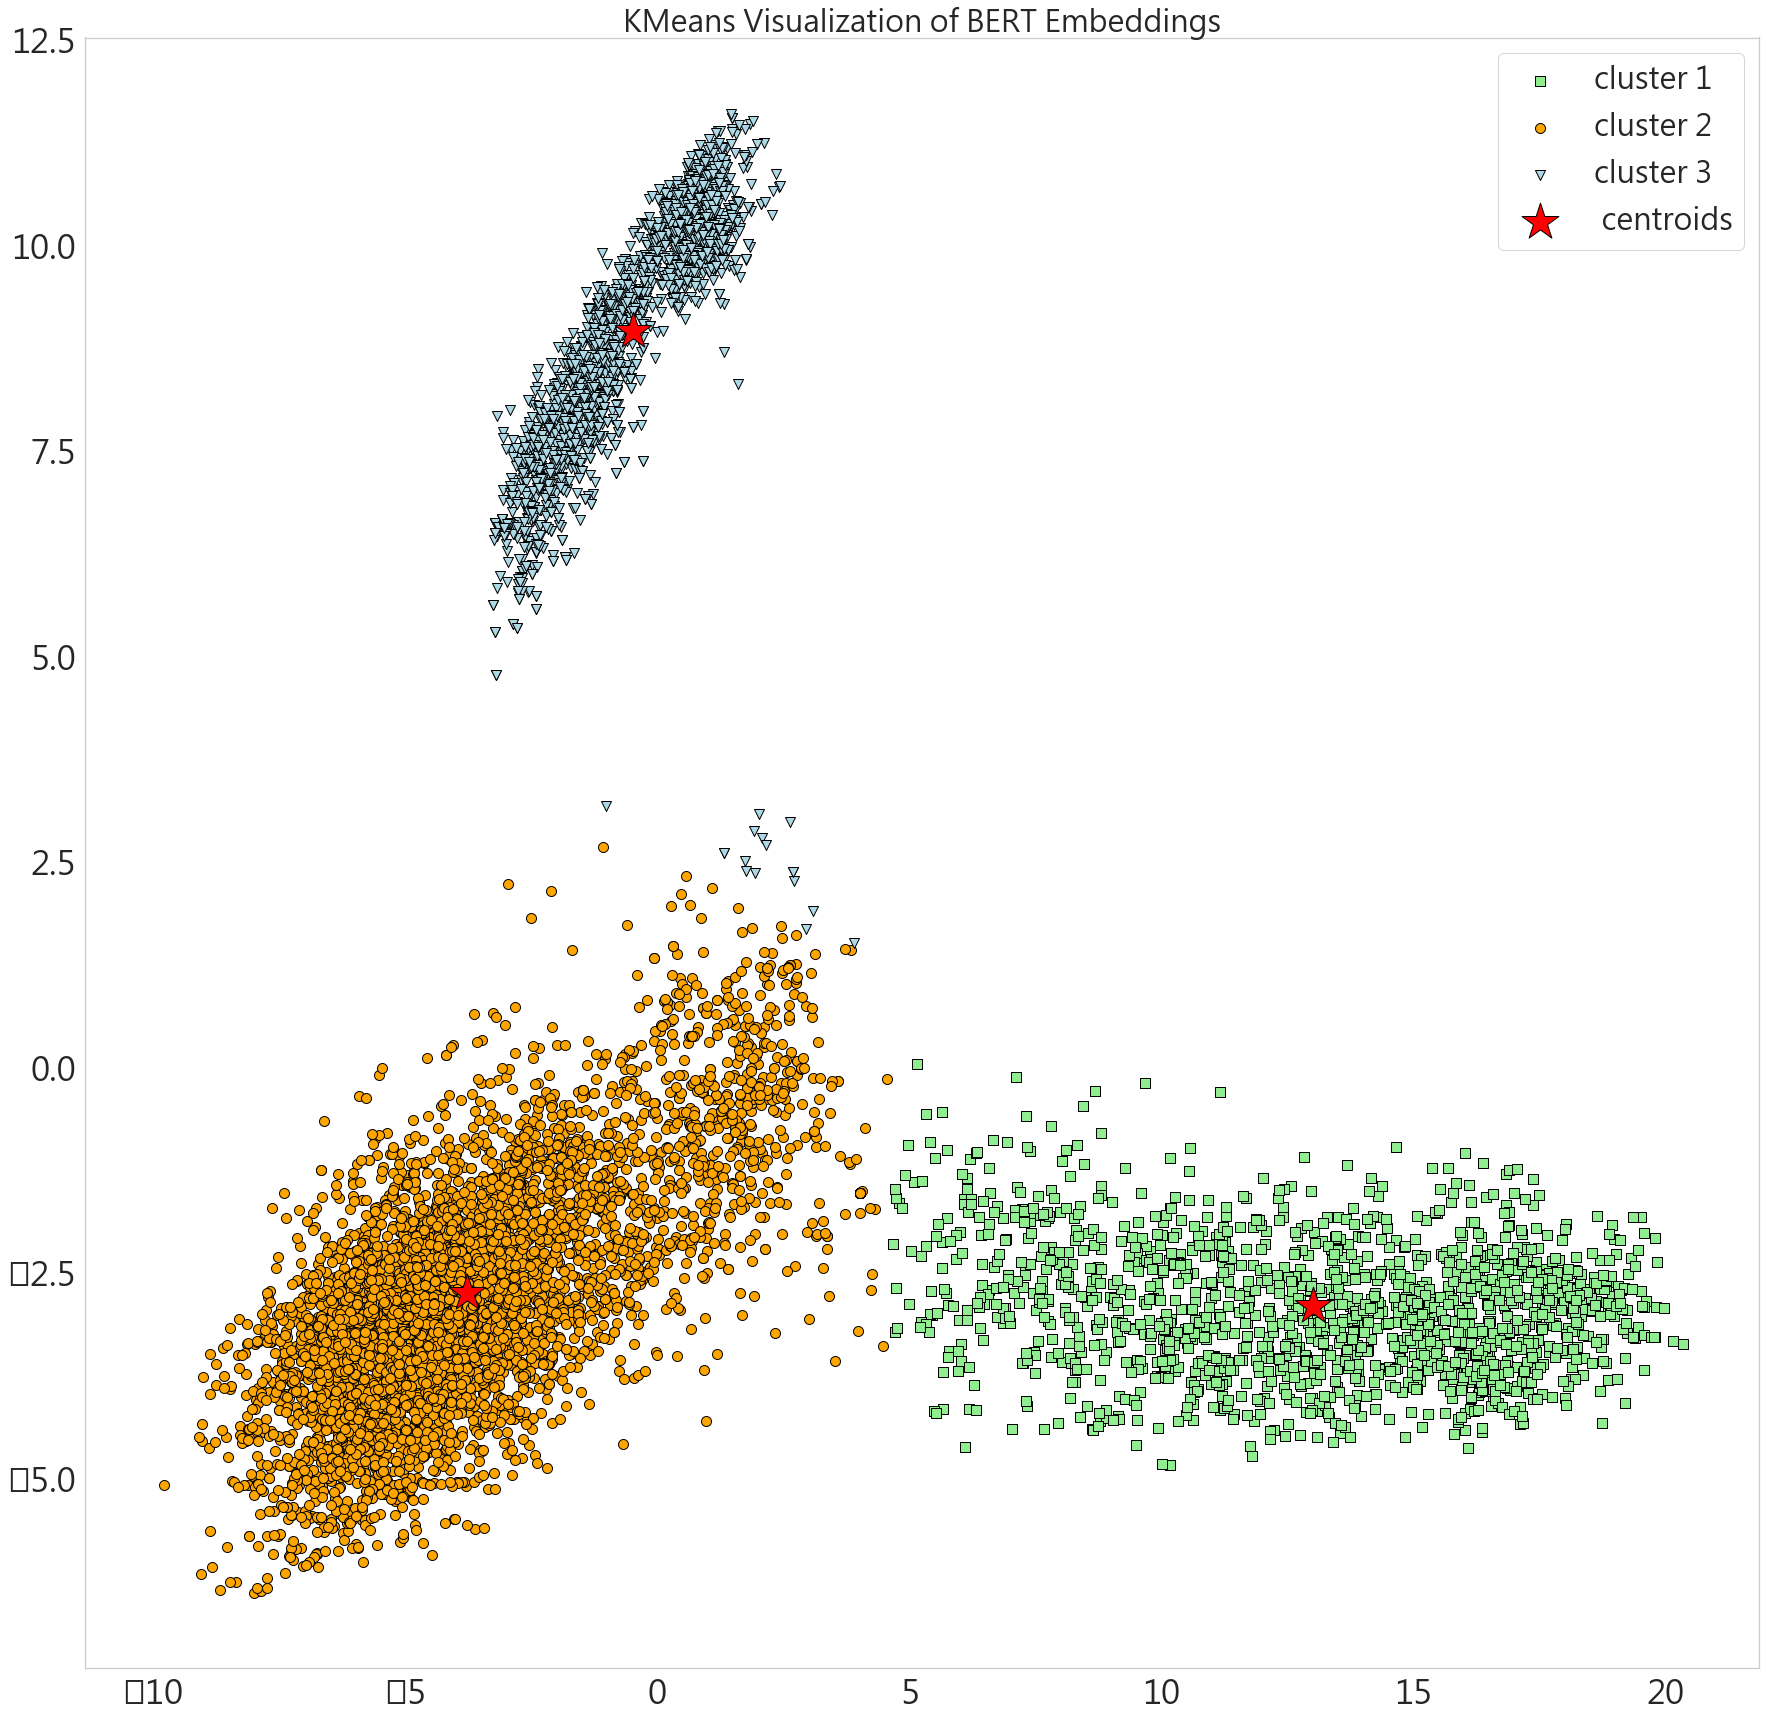

In [51]:
plt.subplots(figsize=(30, 30))
plt.scatter(X[y_km == 0,0],
                X[y_km==0,1],
                s=100, c='lightgreen',
                marker='s', edgecolor='black',
                label='cluster 1')
plt.scatter(X[y_km == 1, 0],
                X[y_km == 1, 1],
                s=100, c='orange',
                marker='o', edgecolor='black',
                label='cluster 2')
plt.scatter(X[y_km == 2,0],
                X[y_km == 2, 1],
                s=100, c='lightblue',
                marker='v', edgecolor='black',
                label='cluster 3')
plt.scatter(km.cluster_centers_[:,0],
                km.cluster_centers_[:, 1],
                s=1500, marker='*',
                c='red', edgecolor='black',
                label=' centroids')
plt.legend (scatterpoints=1,fontsize=30)
plt.grid()
plt.title("KMeans Visualization of BERT Embeddings", fontsize=30)
plt.savefig('kmeans.png')

In [ ]:
ac = AgglomerativeClustering(linkage = 'complete',
                                          affinity = 'euclidean',
                                          n_clusters = 2)

y_km = ac.fit_predict(X)

#### 各群比例

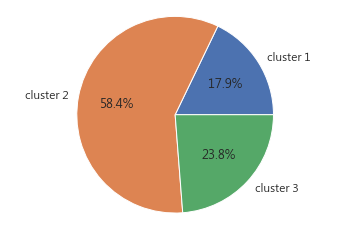

In [204]:
plt.pie([list(y_km).count(0),list(y_km).count(1),list(y_km).count(2)] , labels = ['cluster 1','cluster 2','cluster 3'],autopct='%1.1f%%')
plt.axis('equal')
plt.savefig('cluster_pct')

### TF-IDF

In [9]:
y=0
for i in range(3):
    x = len(df['內文'][0][i])
    y+=x

text_list = sum(df['內文'][0][0:3],[])
doc_names = range(y)

dwc = {key: [word for word in jieba.cut(text, cut_all=False)] for (key, text) in tqdm_notebook(zip(doc_names, text_list))}

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/rk/fg780g753sd952335gvhq0bm0000gn/T/jieba.cache
Loading model cost 0.653 seconds.
Prefix dict has been built succesfully.


In [13]:
dwc = {key: delete_eng_int(doc) for key,doc in dwc.items()}
dwc = {key: [i for i in doc if i not in ['◣','▲','－','▼','違反版','違反板','規請','資料','來源','錯誤','如有','告訴','謝謝','Ｗ','L','Ｌ','的','在','了','是']]for key,doc in dwc.items()}
dwc = {key: [i for i in doc if (len(i) > 1)]for key,doc in dwc.items()}
doc_word_frequency = {key: {i:Counter(doc)[i] for i in Counter(doc)} for key, doc in dwc.items()}
dwf_list = [pd.DataFrame(list(doc.values()), index=doc.keys()) for doc in doc_word_frequency.values()]
nothing  = [i for i in range(len(dwf_list)) if (len(dwf_list[i]) < 1)]
pd.DataFrame(1,index=['No'],columns=[0])

#### 詞頻矩陣

In [20]:
dwf_list = [pd.DataFrame(list(doc.values()), index=doc.keys()) for doc in doc_word_frequency.values()]
#補齊
for i in nothing:
    dwf_list[i] = pd.DataFrame(1,index=['No'],columns=[0])
    
wfm = pd.concat(dwf_list, axis= 1)
wfm = np.transpose(wfm).fillna(0)
wfm.index = doc_word_frequency.keys()

puncs = set_puncs() 
wfm = wfm[list(set(wfm) - set(puncs))]
wfm.head() # 詞頻矩陣完成

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


自塞爾維亞   高點   趁現   購買   強者   雖現   輕人  賽輸球  背後運球   那刻  ...  蘭幫助   收拾  經擊敗  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   

   絕代雙   刺前  一面倒  喬治希爾   更好   車輛  尋球隊  
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0   0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0   0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0   0.0  0.0  0.0  0.0  

[5 rows x 28970 columns]

#### TF-IDF

In [21]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf_gen = transformer.fit_transform(wfm) # 產生一個 tfidf 矩陣的 generator
df_tfidf = pd.DataFrame(tfidf_gen.toarray(), columns=wfm.columns)
df_tfidf.head()

自塞爾維亞   高點   趁現   購買   強者   雖現   輕人  賽輸球  背後運球   那刻  ...  蘭幫助   收拾  經擊敗  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...  0.0  0.0  0.0   

   絕代雙   刺前  一面倒  喬治希爾   更好   車輛  尋球隊  
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0   0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0   0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0   0.0  0.0  0.0  0.0  

[5 rows x 28970 columns]

#### 儲存矩陣

In [22]:
x = wfm.to_dict(orient='records')

In [36]:
with open('TF-IDF', 'w') as fout:
    json.dump(x, fout)
fout.close()

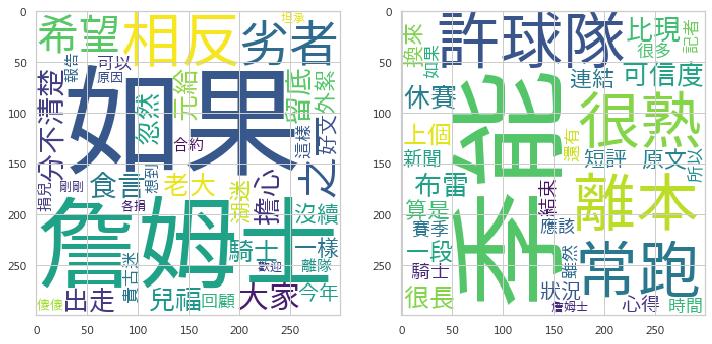

In [48]:
#第幾篇文章
index = 625
first_text = x[index] # 將詞頻矩陣轉換成dictionary, 把文章抽出來
font = r'/Users/howardchung/PPT/字體/TaipeiSansTCBeta-Regular.ttf'

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plot_wordcloud(first_text, ax=ax1, font_path=font, height=300, width=300)

ax2 = plt.subplot(122)
plot_tfidf_wordcloud(df_tfidf, text_index=562, ax=ax2, font_path=font, height=300, width=300) 
plt.savefig('cluster3.png')

### apriori

In [ ]:
d = {}
for i in range(len(doc_word_frequency)):
    d[i] = list(doc_word_frequency[i].keys())

te = TransactionEncoder()
te_ary = te.fit(d.values()).transform(d.values())
df = pd.DataFrame(te_ary, columns=te.columns_)
graph = df.T
graph.columns = d.keys()

minsup = 0.01

In [139]:
result = apriori(graph, min_support = minsup)
result.head()

support itemsets
0  0.013531      (0)
1  0.020469     (38)
2  0.010494     (64)
3  0.013911     (88)
4  0.032447    (119)

In [117]:
rules = association_rules(result, metric="confidence", min_threshold=0.7)
rules.head()

antecedents consequents  antecedent support  consequent support   support  \
0         (0)       (484)            0.013531            0.013531  0.013531   
1       (484)         (0)            0.013531            0.013531  0.013531   
2         (0)       (854)            0.013531            0.013531  0.013531   
3       (854)         (0)            0.013531            0.013531  0.013531   
4         (0)       (934)            0.013531            0.013324  0.013255   

   confidence       lift  leverage  conviction  
0    1.000000  73.903061  0.013348         inf  
1    1.000000  73.903061  0.013348         inf  
2    1.000000  73.903061  0.013348         inf  
3    1.000000  73.903061  0.013348         inf  
4    0.979592  73.520144  0.013075   48.347118

In [118]:
rules = association_rules(result, metric="lift", min_threshold=1.2)
rules.head()

antecedents consequents  antecedent support  consequent support   support  \
0         (0)       (484)            0.013531            0.013531  0.013531   
1       (484)         (0)            0.013531            0.013531  0.013531   
2         (0)       (854)            0.013531            0.013531  0.013531   
3       (854)         (0)            0.013531            0.013531  0.013531   
4         (0)       (934)            0.013531            0.013324  0.013255   

   confidence       lift  leverage  conviction  
0    1.000000  73.903061  0.013348         inf  
1    1.000000  73.903061  0.013348         inf  
2    1.000000  73.903061  0.013348         inf  
3    1.000000  73.903061  0.013348         inf  
4    0.979592  73.520144  0.013075   48.347118

In [119]:
rules["antecedant_len"] = rules["antecedents"].apply(lambda x: len(x))
rules.head()

antecedents consequents  antecedent support  consequent support   support  \
0         (0)       (484)            0.013531            0.013531  0.013531   
1       (484)         (0)            0.013531            0.013531  0.013531   
2         (0)       (854)            0.013531            0.013531  0.013531   
3       (854)         (0)            0.013531            0.013531  0.013531   
4         (0)       (934)            0.013531            0.013324  0.013255   

   confidence       lift  leverage  conviction  antecedant_len  
0    1.000000  73.903061  0.013348         inf               1  
1    1.000000  73.903061  0.013348         inf               1  
2    1.000000  73.903061  0.013348         inf               1  
3    1.000000  73.903061  0.013348         inf               1  
4    0.979592  73.520144  0.013075   48.347118               1

In [120]:
out = rules[ (rules['antecedant_len'] >= 2) &
       (rules['confidence'] > 0.75) &
       (rules['lift'] > 1.2) ]
out.head()

antecedents consequents  antecedent support  consequent support   support  \
344    (0, 484)       (854)            0.013531            0.013531  0.013531   
345    (0, 854)       (484)            0.013531            0.013531  0.013531   
346  (484, 854)         (0)            0.013531            0.013531  0.013531   
350    (0, 484)       (934)            0.013531            0.013324  0.013255   
351    (0, 934)       (484)            0.013255            0.013531  0.013255   

     confidence       lift  leverage  conviction  antecedant_len  
344    1.000000  73.903061  0.013348         inf               2  
345    1.000000  73.903061  0.013348         inf               2  
346    1.000000  73.903061  0.013348         inf               2  
350    0.979592  73.520144  0.013075   48.347118               2  
351    1.000000  73.903061  0.013076         inf               2

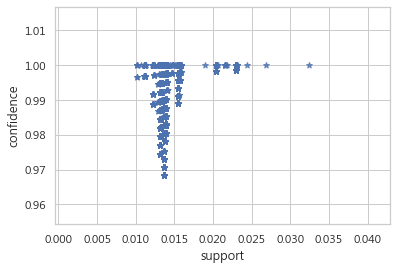

In [121]:
support = rules['support']
confidence = rules['confidence']
plt.scatter(support, confidence, alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

In [122]:
len(rules)
rules['antecedents'].head()

0      (0)
1    (484)
2      (0)
3    (854)
4      (0)
Name: antecedents, dtype: object

In [124]:
import networkx as nx
G = nx.DiGraph()
for i in range(len(d.keys())):
    G.add_node(i)
for i in range(len(rules['antecedents'])):
    currentFrom = list(rules['antecedents'][i])
    currentTo = list(rules['consequents'][i])
    for j in range(len(currentFrom)):
        G.add_edge(currentFrom[j], currentTo[0])

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


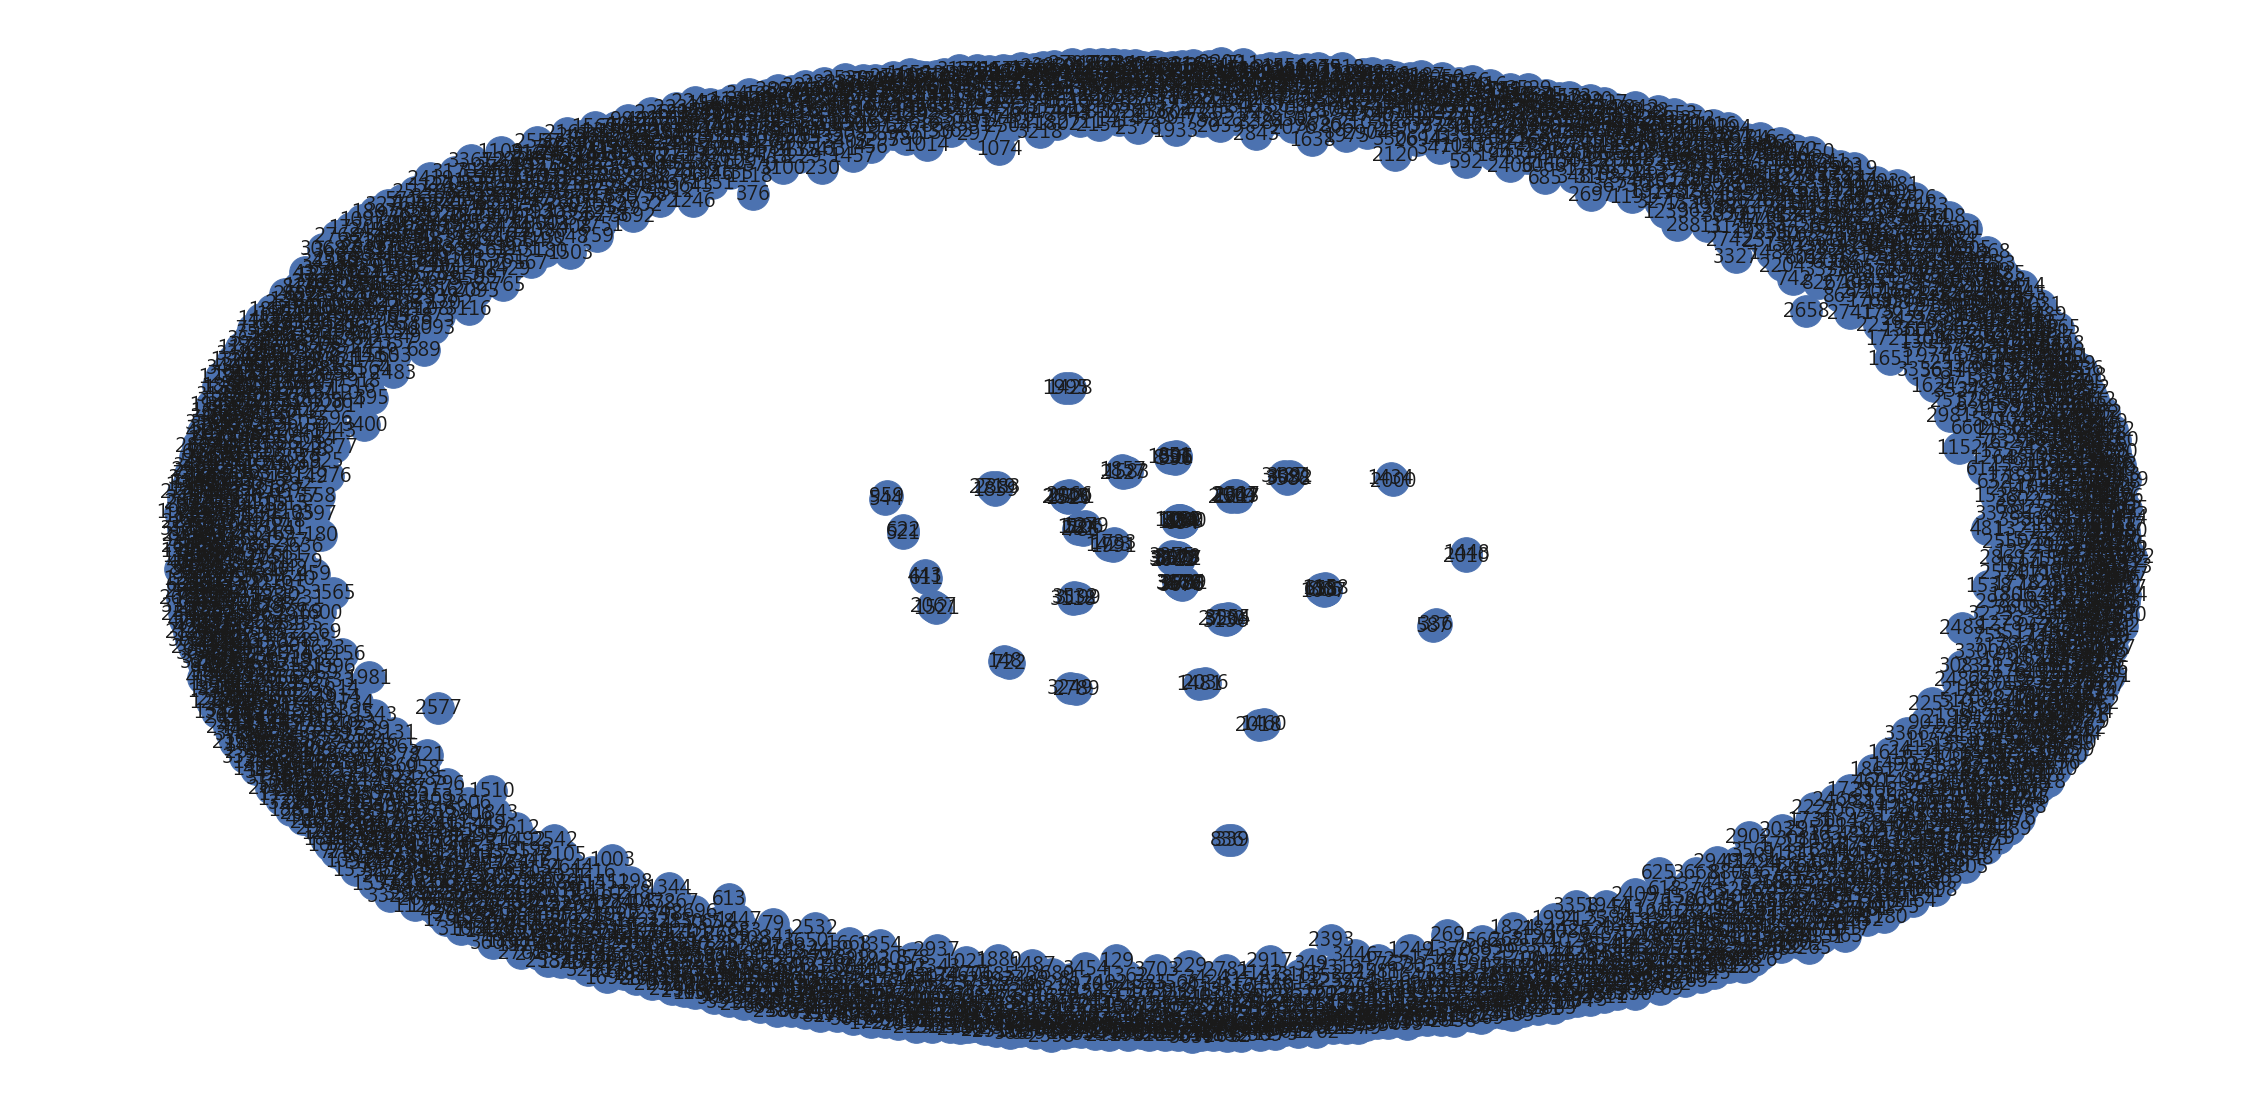

In [127]:
nodeList = list(range(3709))

plt.figure(figsize=(40,20))

# positions for all nodes
pos = nx.fruchterman_reingold_layout(G)

# nodes
nx.draw_networkx_nodes(G, pos, nodelist=nodeList, node_color="b", node_size=1000)
nx.draw_networkx_edges(G, pos, width=6)

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.axis('off')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display

## 結論

1. 以聲量來看可以發現只要有球星幾乎都可以讓討論度大幅增加，這也是球星的行銷價值所在
2. 接下來根據LeBron James的個人聲量做分析可以發現以BERT做Embedding可以有效的將內容分類成三群，但是關聯式規則就無法將這些內文分類，原因是在embedding-base的模型並不是要完全一樣的字才能計算相似度，但是在Vector-base就會導致association rule的計算把每個都算成不同的資料點